In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_extraction import DictVectorizer

import warnings
warnings.filterwarnings('ignore')

- Dataset

In [2]:
URL = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

- Features

In [3]:
features = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP"
]

- Data preparation

In [4]:
df = pd.read_csv(URL)
df = df[features]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.rename(columns={"msrp" : "price"})
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


**Question 1**

What is the most frequent observation (mode) for the column `transmission_type`?

In [5]:
df['transmission_type'].value_counts()

transmission_type
AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: count, dtype: int64

Answer: **AUTOMATIC**

In [6]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

In [7]:
df = df.fillna(0)

**Question 2**

Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

In [8]:
df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
price                  int64
dtype: object

In [9]:
numerical_features = [
    "year",
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg",
    "price"
]

<Axes: >

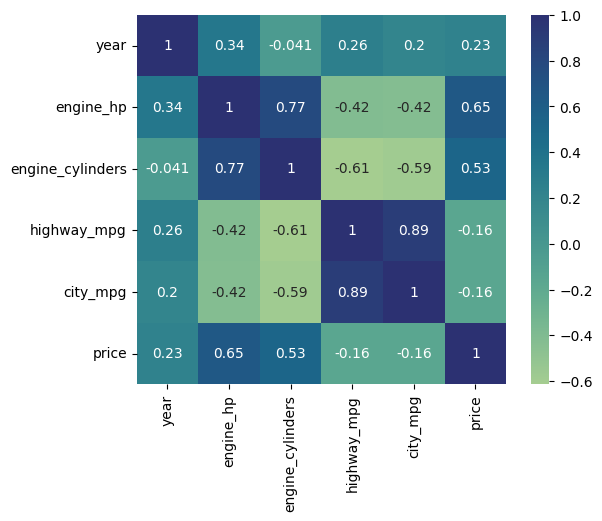

In [10]:
sns.heatmap(df[numerical_features].corr(), 
            annot=True,
            square=True, 
            fmt=".2g",
            cmap="crest")

`highway_mpg` and `city_mpg`

- Make price binary

In [11]:
df["above_average"] = [1 if x > df["price"].mean() else 0 for x in df["price"]]
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


- Split the data

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [13]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values

In [16]:
del df_train['price']
del df_val['price']
del df_test['price']

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

**Question 3**


Calculate the mutual information score between `above_average` and other categorical variables in our dataset. Use the training set only.
Round the scores to 2 decimals using round(score, 2).

Which of these variables has the lowest mutual information score?

In [17]:
categorical = ["make", "model", "transmission_type", "vehicle_style"]

In [18]:
def mutual_info_churn_score(series):
    return round(mutual_info_score(series, y_train), 2)

In [19]:
mi = df_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

model                0.46
make                 0.24
vehicle_style        0.08
transmission_type    0.02
dtype: float64

**Answer** : Model

**Question 4**


- Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
        `model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)`
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [20]:
numerical = [
    "year",
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg"
]

In [21]:
dv = DictVectorizer(sparse=False)

In [22]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
model = LogisticRegression(solver="liblinear",
                           C=10,
                           max_iter=1000,
                           random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [24]:
y_pred = model.predict_proba(X_val)[:, 1]

In [25]:
churn_decision = (y_pred >= 0.5)

In [26]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred['prediction'] == df_pred['actual']
df_pred.head()

,probability,prediction,actual,correct
0,0.000845,0,0,True
1,0.996342,1,1,True
2,0.000150,0,0,True
3,0.228858,0,0,True
4,0.001525,0,0,True


In [27]:
print(f"Accuracy: {round(df_pred['correct'].mean(), 2)}")

Accuracy: 0.95


**Question 5**

- Let's find the least useful feature using the feature elimination technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

In [28]:
accuracy = df_pred['correct'].mean()

In [29]:
features = categorical + numerical

In [30]:
orig_score = accuracy

for c in features:
    subset = features.copy()
    subset.remove(c)
    
    train_dict = df_train[subset].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    model = LogisticRegression(solver="liblinear",
                               C=10,
                               max_iter=1000,
                               random_state=42)
    model.fit(X_train, y_train)

    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict(X_val)

    score = accuracy_score(y_val, y_pred)
    print(f"feature: {c}, difference between scores: {orig_score - score}, actual score: {score}")

feature: make, difference between scores: -0.0016785564414603105, actual score: 0.9467058329836341
feature: model, difference between scores: 0.020981955518254325, actual score: 0.9240453210239195
feature: transmission_type, difference between scores: 0.0, actual score: 0.9450272765421738
feature: vehicle_style, difference between scores: 0.012589173310952662, actual score: 0.9324381032312211
feature: year, difference between scores: -0.002937473772555599, actual score: 0.9479647503147294
feature: engine_hp, difference between scores: 0.01720520352496857, actual score: 0.9278220730172052
feature: engine_cylinders, difference between scores: -0.0008392782207301552, actual score: 0.9458665547629039
feature: highway_mpg, difference between scores: -0.0016785564414603105, actual score: 0.9467058329836341
feature: city_mpg, difference between scores: 0.012589173310952662, actual score: 0.9324381032312211


**Answer**: Year

**Question 6**

- For this question, we'll see how to use a linear regression model from Scikit-Learn.
- We'll need to use the original column price. Apply the logarithmic transformation to this column.
- Fit the Ridge regression model on the training data with a solver 'sag'. Set the seed to 42.
- This model also has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10].
- Round your RMSE scores to 3 decimal digits.

Which of these alphas leads to the best RMSE on the validation set?

In [31]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [32]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [33]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [34]:
y_train = np.log1p(df_train['price'].values)
y_val = np.log1p(df_val['price'].values)
y_test = np.log1p(df_test['price'].values)

In [35]:
del df_train['price']
del df_val['price']
del df_test['price']

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [36]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [37]:
alpha = [0, 0.01, 0.1, 1, 10]

for i in alpha:
    model = Ridge(alpha = i,
                solver="sag",
                random_state = 42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    score = rmse(y_val, y_pred)
    
    print(f"r = {i} ; rmse = {round(score, 3)}")

r = 0 ; rmse = 0.49
r = 0.01 ; rmse = 0.49
r = 0.1 ; rmse = 0.49
r = 1 ; rmse = 0.49
r = 10 ; rmse = 0.49


**Answer:** 0